# MCMC Simulation of Potts model
$$
H(\sigma) = -J \sum_{\langle i,j \rangle} \delta_{\sigma_i, \sigma_j} - h \sum_i {\sigma_i} \,, \quad i \in \{1, \dots, N^2\}
$$
where $\sigma_i \in \{1, \dots, q\}$ is the spin at site $i$. Take $q=3$ and $q=10$ as concrete examples.


### Internal energy and specific heat
Take $J=1$ and $h=0$ and $k_B=1$. Plot the internal energy $u$
$$
u = \frac{1}{N^2} \langle H(\sigma) \rangle
$$
and the specific heat $c$
$$
c = \frac{k_B \beta^2}{N^2} \left( \langle H(\sigma)^2 \rangle - \langle H(\sigma) \rangle^2 \right)
$$
as the function of temperature $T$ where $\beta=(k_B T)^{-1}$ and $Z=\sum_\sigma e^{-\beta H(\sigma)}$ is the partition function. Identify the critical temperature $T_*$ of the phase transition when $N$ is large.
### Magnetization
For different temperatures $T$, plot the magnetization $m$
$$
m = \frac{1}{N^2} \left\langle \sum_i \sigma_i, 1 \right\rangle
$$
### Spatial correlation
Define the spatial correlation function
$$
C(i,j) = \langle \sigma_i \sigma_j \rangle - \langle \sigma_i \rangle \langle \sigma_j \rangle
$$
and the correlation length $\xi$ as the characteristic length that $\Gamma(k)=C(i,j)|_{|i-j|=k}$ decays to zero. $\Gamma(k)$ can be approximated by computing the average
$$
\Gamma(k) = \frac{1}{4N^2} \sum_i \sum_{j \in S_i} C(i,j)
$$
where the set 
$$
S_i = \{ j| i-j = \pm(k,0) \text{ or } \pm(0,k) \}
$$
the constant 4 is from four points in $S_i$. The correlation length can the be defined through
$$
\Gamma(k) \propto \Gamma_0 e^{-k/\xi} \quad k \gg 1
$$
Study the correlation length $\xi$ as the function of temperature $T$ when $h=0$.
### Behaviour of $c$ and $\xi$
When $h=0$, investigating the bahaviour of $c$ and $\xi$ around the critical temperature $T_*$ if we assume the limiting behaviour
$$
c \sim c_0 \epsilon^{-\gamma}, \quad \xi \sim \xi_0 \epsilon^{-\delta}
$$
where $\epsilon = |1-T/T_*|$. Numerically find the values of $\gamma$ and $\delta$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from numba import njit,prange,objmode,jit
# setup of 2D q-state Potts model
@njit
def potts_energy(spins, J, h):
    """计算Potts模型的能量

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目
        J: 相邻自旋互相作用能量强度

    Returns:
        系统总能量,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算相邻自旋互作用能
    E_J = J * np.sum(spins[:-1, :] == spins[1:, :])
    E_J += J * np.sum(spins[:, :-1] == spins[:, 1:])
    E_J += h * np.sum(spins)

    # 求和得到能量
    E = -E_J
    return E

# magnetization
@njit
def potts_magnetization(spins):
    """计算Potts模型的磁化强度

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目

    Returns:
        系统磁化强度,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算磁化强度
    M = np.sum(spins) / N**2
    return M

In [2]:
q = 3
N = 20
J = 1
h = 0
k = 1
T_series = np.linspace(0.5,2.5,100)
n_steps = 400000

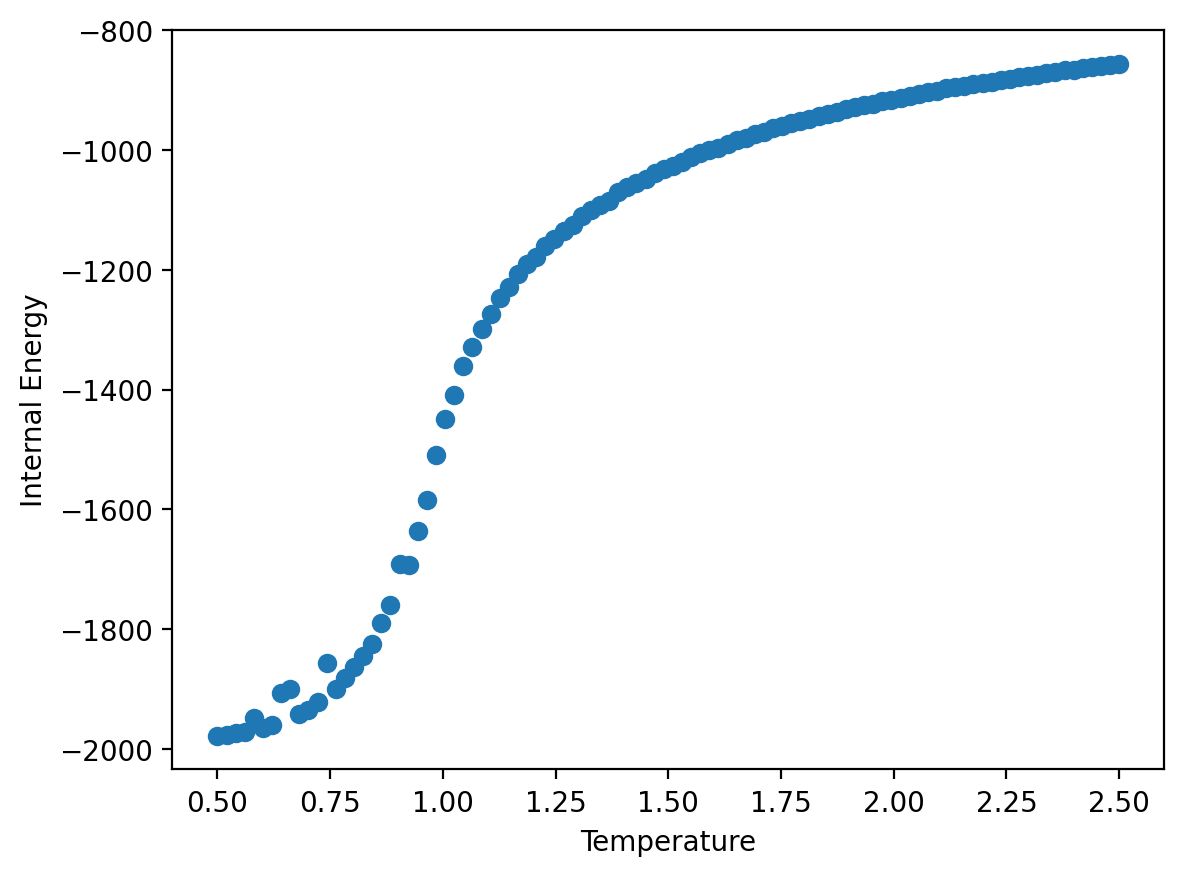

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# internal energy
@jit
def internal_energy(spin_series, J, h):
    """计算内能
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        内能,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 求和得到内能
    E = np.mean(E_series)
    return E

import os.path
# internal energy
U_series = np.zeros(shape=(len(T_series)))
for i in range(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        U_series[i] = internal_energy(data, J, h)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, U_series, 'o')
plt.xlabel('Temperature')
plt.ylabel('Internal Energy')
plt.show()


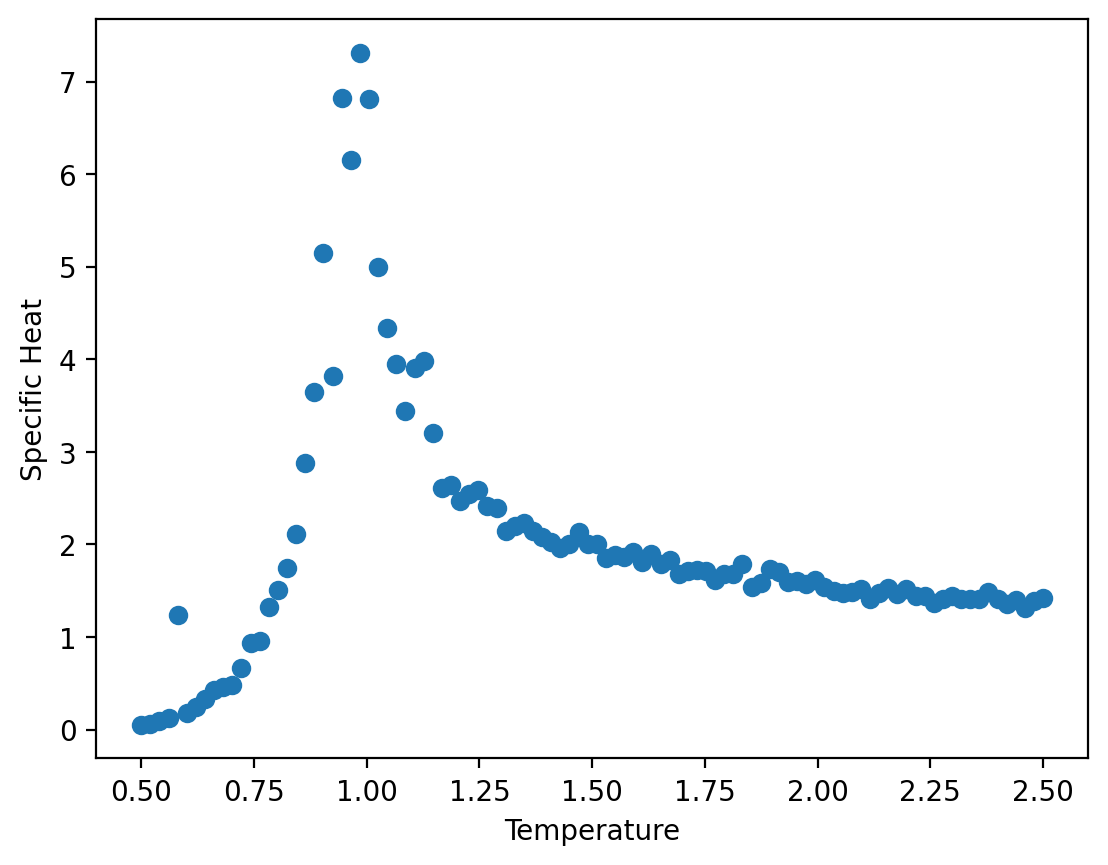

In [14]:
# specific heat
@jit
def specific_heat(spin_series, J, h, N):
    """计算比热
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        比热,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 计算能量平方
    E2_series = E_series**2
    # 求和得到比热
    C = np.mean(E2_series) - np.mean(E_series)**2
    C = C / N**2
    return C

# specific heat
C_series = np.zeros(shape=(len(T_series)))
for i in range(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        C_series[i] = specific_heat(data, J, h, N)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, C_series, 'o')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.show()

In [15]:
# find critical temperature (peak of specific heat)
T_c = T_series[np.argmax(C_series)]
print('Critical Temperature: {:.2f}'.format(T_c))

Critical Temperature: 0.98


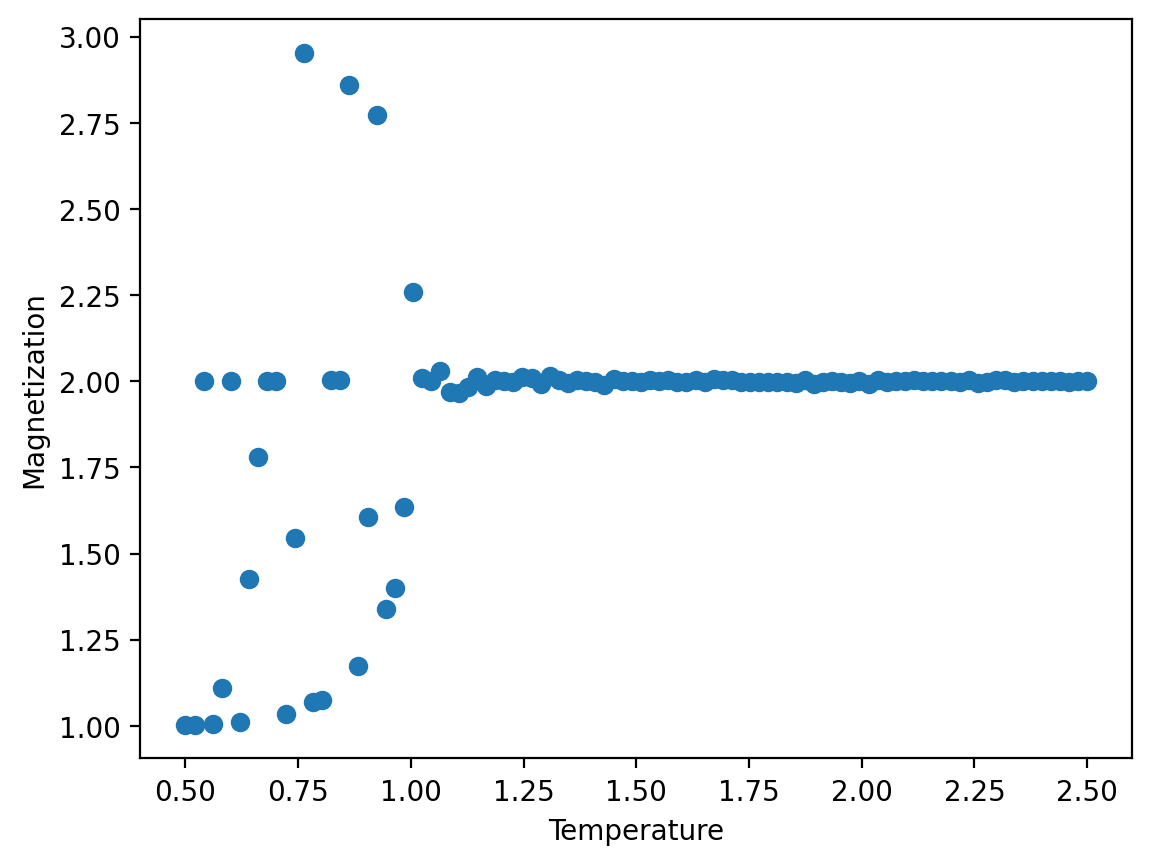

In [16]:
# magnetization
@jit
def magnetization(spin_series):
    """计算磁化强度
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
    Returns:
        磁化强度,标量
    """
    
    # 计算磁化强度
    M_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        M_series[i] = potts_magnetization(spin_series[i,:,:])
    # 求和得到磁化强度
    M = np.mean(M_series)
    return M

M_series = np.zeros(shape=(len(T_series)))
for i in range(len(T_series)):
    T = T_series[i]
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        M_series[i] = magnetization(data)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, M_series, 'o')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

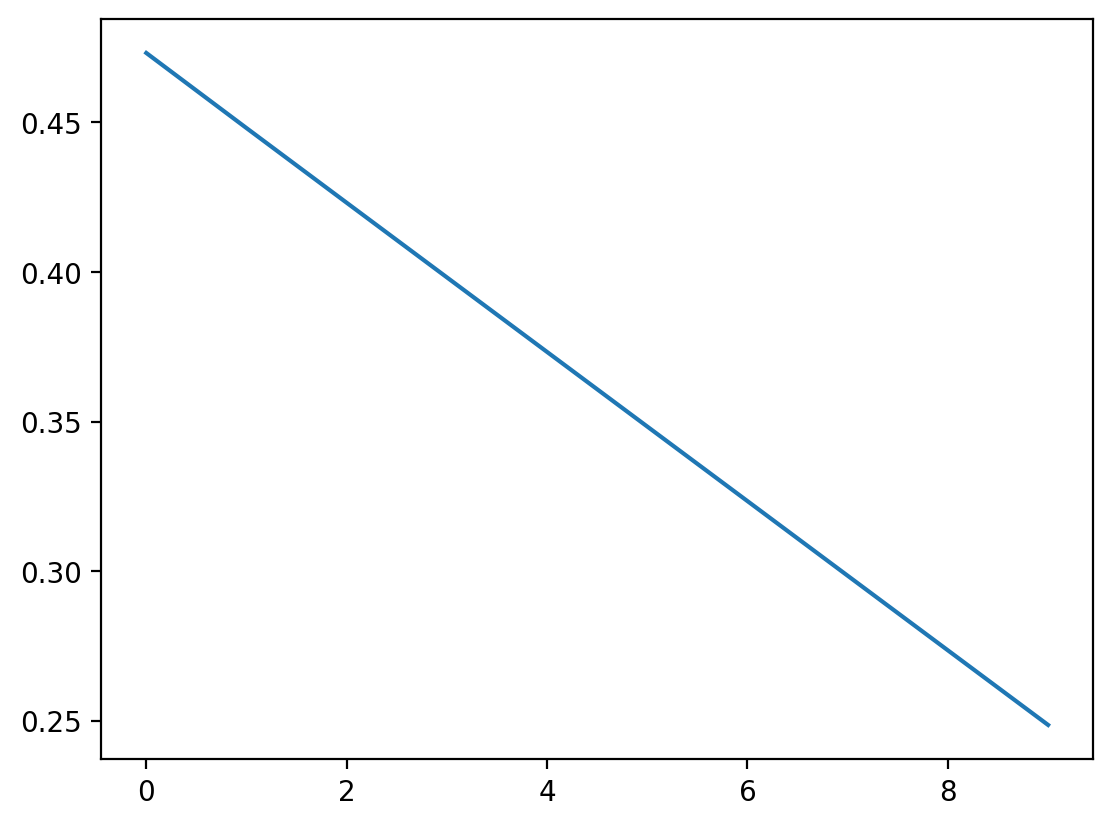

In [10]:
# space correlation and characteristic length
@jit
def space_correlation(spin_series, J, h, k):
    """计算空间相关函数
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
        k: |i-j|
    Returns:
        Gamma: 空间相关函数 \Gamma(k) = 1/(4N^2) sum_i sum_{j=i+-(0,k) or (k,0)} <s_i s_j>-<s_i><s_j>
    """
    
    

from scipy.optimize import curve_fit
def characteristic_length(Gamma):
    """计算特征长度
    Args:
        Gamma: 空间相关函数
    Returns:
        xi: 特征长度,标量 Gamma(k) = exp(-k/xi)
    """
        
    # 计算特征长度
    x = np.arange(1,Gamma.shape[0]+1)
    xi, _ = curve_fit(lambda x, xi: np.exp(-x/xi), x, Gamma)
    return xi

xi_series = np.zeros(shape=(len(T_series)))
for T in T_series:
    beta = 1/(k*T)
    # load data
    if os.path.isfile('Potts_Data_new/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data_new/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        Gamma = space_correlation(data, J, h)
        # plot Gamma
        if T == T_series[0]:
            plt.plot(Gamma)
        xi_series[i] = characteristic_length(Gamma)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
#plt.plot(T_series, xi_series, 'o')
#plt.xlabel('Temperature')
#plt.ylabel('Characteristic Length')
plt.show()
